In [263]:
from __future__ import print_function
from collections import Counter
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import calendar
import datetime
from math import log
from scipy import stats

In [2]:
#load the pickle object for quick access
result = pd.read_pickle("/Users/Matt/Documents/Stevens/BIA660 Web Analytics/yelp_dataset_challenge_academic_dataset/Data/500_Dataset")

In [437]:
def exploreBusiness(businessID):
    #exploratory Analysis for business ID mpDxBBGywUE6GRRKja3sBA
    business1 = result[result["business_id"]==businessID]
    #change date into datetime
    business1['date'] = pd.to_datetime(business1['date'])
    business1['Year-Month'] = business1.date.map(lambda x: x.strftime('%Y-%m'))
    business1['Qdate'] = [date - pd.tseries.offsets.DateOffset(days=1) + pd.tseries.offsets.QuarterEnd() for date in business1.date]
    #review_counts = business1.groupby('Year-Month')['review_id'].count()
    review_counts = business1.groupby('Year-Month')['stars_x'].count()
    ax = review_counts.plot(kind='bar', figsize=(20,10))
    return ax, review_counts

/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

(<matplotlib.axes._subplots.AxesSubplot at 0x12adaf710>, Year-Month
 2006-11     2
 2007-06     2
 2007-07     1
 2007-08     1
 2007-12     1
 2008-01     1
 2008-02     1
 2008-03     5
 2008-04     2
 2008-05     6
 2008-07     4
 2008-08     2
 2008-09     2
 2008-10     2
 2008-11     3
 2008-12     4
 2009-01     3
 2009-02     1
 2009-03     1
 2009-04     3
 2009-05     2
 2009-07     3
 2009-08     3
 2009-09     1
 2009-10     1
 2009-12     5
 2010-01     3
 2010-02     2
 2010-03     1
 2010-04     2
            ..
 2014-02    22
 2014-03    17
 2014-04    26
 2014-05    21
 2014-06    24
 2014-07    30
 2014-08    28
 2014-09    17
 2014-10    24
 2014-11    17
 2014-12    13
 2015-01    21
 2015-02    17
 2015-03    15
 2015-04    18
 2015-05    20
 2015-06    12
 2015-07    23
 2015-08    29
 2015-09    19
 2015-10    12
 2015-11    11
 2015-12    16
 2016-01    19
 2016-02    15
 2016-03    12
 2016-04    17
 2016-05    27
 2016-06    28
 2016-07    13
 Name: stars_x, d

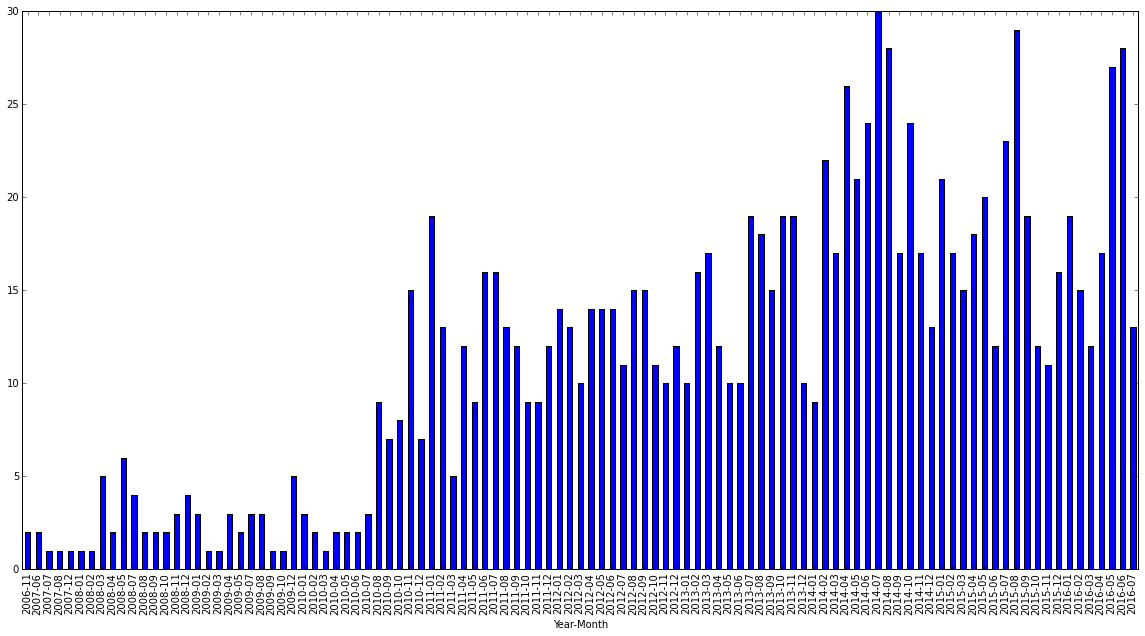

In [438]:
exploreBusiness('3Q0QQPnHcJuX1DLCL9G9Cg')

In [462]:
def slidingTtest(review_counts):
    anomaly = {} #initialize dict
    d = {}
    anomaly = {}
    for ind, value in review_counts.iteritems():
        d[ind] = value
        #print(ind)
        if len(d) >= 31: #need 30 samples because the data is non-normal
            #t-test to compare the next month/year sample to the mean of all the prior ones   
            one_sample = stats.ttest_1samp(d.values()[0:(len(d)-2)], d.values()[len(d)-1]) #compares the entire period
            if one_sample.pvalue < 0.05: #null hypothesis: new sample = prior mean
                anomaly[ind]=1  #there is a statistically signifant difference, where the new sample != prior mean
            else:
                anomaly[ind]=0 #no evidence of a difference
    return anomaly

In [463]:
slidingTtest(review_counts)

{'2010-05': 1,
 '2010-06': 1,
 '2010-07': 1,
 '2010-08': 1,
 '2010-09': 1,
 '2010-10': 1,
 '2010-11': 1,
 '2010-12': 1,
 '2011-01': 1,
 '2011-02': 0,
 '2011-03': 0,
 '2011-04': 0,
 '2011-05': 0,
 '2011-06': 0,
 '2011-07': 0,
 '2011-08': 0,
 '2011-09': 0,
 '2011-10': 0,
 '2011-11': 0,
 '2011-12': 0,
 '2012-01': 0,
 '2012-02': 0,
 '2012-03': 0,
 '2012-04': 0,
 '2012-05': 0,
 '2012-06': 0,
 '2012-07': 0,
 '2012-08': 1,
 '2012-09': 1,
 '2012-10': 1,
 '2012-11': 1,
 '2012-12': 1,
 '2013-01': 1,
 '2013-02': 1,
 '2013-03': 1,
 '2013-04': 1,
 '2013-05': 1,
 '2013-06': 1,
 '2013-07': 1,
 '2013-08': 1,
 '2013-09': 1,
 '2013-10': 1,
 '2013-11': 1,
 '2013-12': 1,
 '2014-01': 1,
 '2014-02': 1,
 '2014-03': 1,
 '2014-04': 1,
 '2014-05': 1,
 '2014-06': 1,
 '2014-07': 1,
 '2014-08': 1,
 '2014-09': 1,
 '2014-10': 1,
 '2014-11': 1,
 '2014-12': 1,
 '2015-01': 1,
 '2015-02': 1,
 '2015-03': 1,
 '2015-04': 1,
 '2015-05': 1,
 '2015-06': 1,
 '2015-07': 1,
 '2015-08': 1,
 '2015-09': 1,
 '2015-10': 1,
 '2015-11'